# Playing around with a neural ODE for dense image tasks

In [1]:
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torchdiffeq import odeint
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

In [2]:
%matplotlib notebook

plt.rcParams["animation.html"] = "jshtml"
plt.rcParams['figure.dpi'] = 150  

def animate_frames(frames: torch.Tensor, draw_func=None):
    if draw_func is None:
        def draw_func(ax, t, frames):
            ax.cla()
            ax.imshow(frames[t])
            ax.set_title(str(t))
    fig, ax = plt.subplots()
    f = lambda t: draw_func(ax, t % len(frames), frames)
    return FuncAnimation(fig, func=f, frames=len(frames))

In [3]:
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

train_size = int(0.8 * len(dataset))
tiny_train_size = 1024
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
tiny_train_dataset, _ = random_split(train_dataset, [tiny_train_size, train_size - tiny_train_size])

batch_size = 512
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
tiny_train_loader = DataLoader(tiny_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Files already downloaded and verified


In [4]:
device = torch.device('mps') if torch.backends.mps.is_available() else torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [5]:
# %matplotlib inline
# x, y = next(iter(test_loader))
# print(x.shape)
# # print(x[0])
# plt.imshow(x[0].permute(1, 2, 0))
# y[0]

In [6]:
class Node(nn.Module):
    """ Neural ode with i/o. """

    class Func(nn.Module):
        """ for use as dstate/dt = Func(t, (input, state)) """
        def __init__(self, d):
            super(Node.Func, self).__init__()
            self.fc1 = nn.Linear(2*d, 2*d)
            self.fc2 = nn.Linear(2*d, d)
            self.fc3 = nn.Linear(d, d)

        def forward(self, t, x):
            """ x should be (inp, state), with inp.shape = state.shape = (B, d) """
            x = torch.concat(x, dim=1)
            x = F.softplus(self.fc1(x))
            x = F.softplus(self.fc2(x))
            return self.fc3(x)

    def __init__(self, c, h, w):
        super(Node, self).__init__()
        self.dim = c * h * w
        self.dxdt = Node.Func(self.dim)

    def forward(self, inp, init_cond=None, t_eval=None, return_trajectories=False, rtol=1e-5, atol=1e-5, method='rk4'):
        B, C, H, W = inp.shape

        if init_cond is None:
            state = torch.randn(B, self.dim, requires_grad=True).to(device)
        else:
            assert inp.shape == init_cond.shape
            state = init_cond.reshape(B, self.dim).to(device)

        if t_eval is None:
            t_eval = torch.Tensor([0, 1]).to(device)

        dxdt = lambda t, state: self.dxdt(t, (inp.view(B, -1), state))
        trajectories = odeint(dxdt, state, t=t_eval, rtol=rtol, atol=atol, method=method)
        if return_trajectories:
            return trajectories.reshape(len(t_eval), B, C, H, W)
        return trajectories[0].reshape(B, C, H, W)

In [7]:
model = Node(3, 32, 32)
model.to(device)
train_losses = []

In [8]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.101)

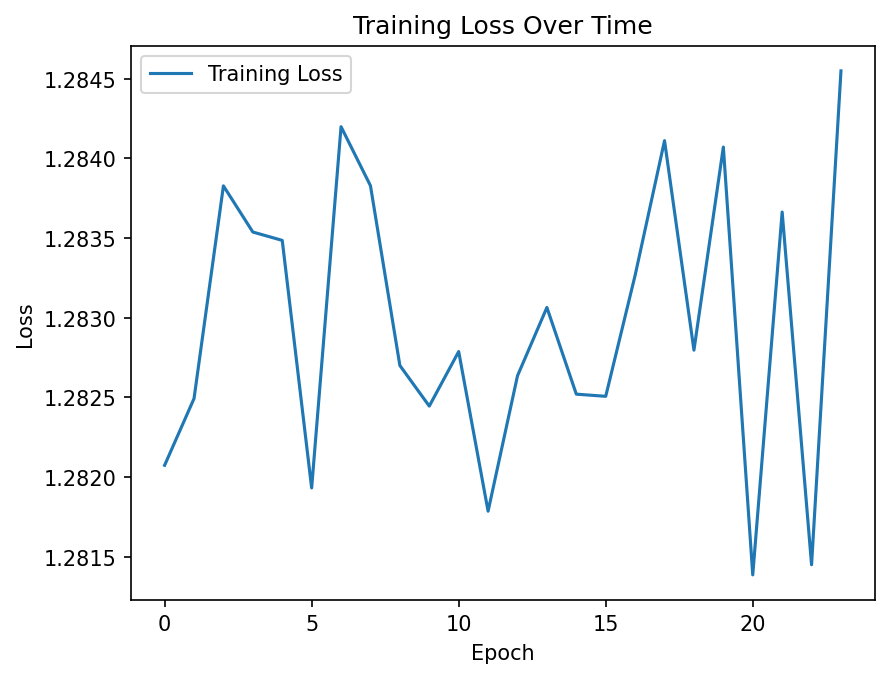

In [23]:
num_epochs = 4

for epoch in range(num_epochs):
    t0 = time.time()
    model.train()
    running_loss = 0.0
    end_time = 7 + 6*torch.rand(1).item() # 10 +/- 3
    t_eval = torch.Tensor([0, end_time]).to(device)
    for idx, (images, labels) in enumerate(tiny_train_loader):
        optimizer.zero_grad()
        images = images.to(device)
        outputs = model(images, t_eval=t_eval)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    average_loss = running_loss / len(tiny_train_loader)
    train_losses.append(average_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss:.4f},      s/it: {time.time() - t0:.4f}", end='\r')

%matplotlib inline
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()
plt.show()

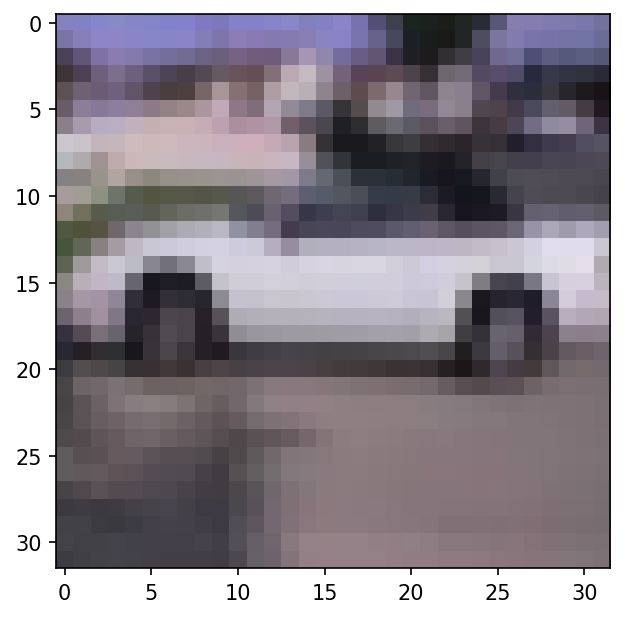

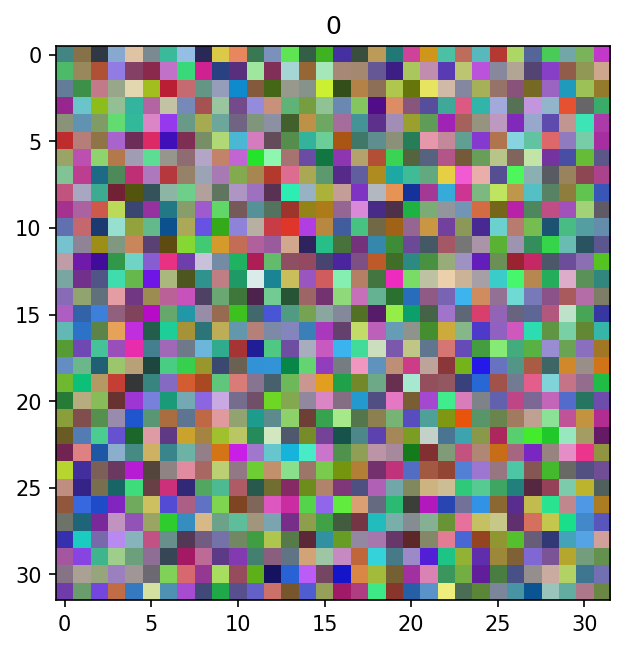

In [21]:
x, _ = next(iter(train_loader)) 
frame = x[0]
inp = frame.reshape(1, *x[0].shape).to(device)

end_time = 15
trajectories = model(inp, t_eval=torch.linspace(0, end_time, 30), return_trajectories=True)
trajectories = trajectories.detach()

plt.imshow(frame.cpu().permute(1, 2, 0))
animate_frames(torch.sigmoid(trajectories.cpu().squeeze(1).permute(0, 2, 3, 1)))

### this doesnt work.. lets take some inspiration from diffusion models, and train on trajectories rather than just final state
generate intermediate targets with a reverse gaussain blurring process